In [1]:
import pandas as pd
import os
import time
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Masking, LSTM, Dense

from LSTM.naive_preprocess import process_data
from LSTM.LSTM_classifier import BiLSTMclf
from LSTM.Config import Options as opts
from tools.tools import evaluate

#### Load and preprocess data

In [2]:
pos_train_path = os.path.join('Data', 'pos_train.csv')
pos_train = pd.read_csv(pos_train_path)

neg_train_path = os.path.join('Data', 'neg_train.csv')
neg_train = pd.read_csv(neg_train_path)

pos_test_path = os.path.join('Data', 'pos_test.csv')
pos_test = pd.read_csv(pos_test_path)

neg_test_path = os.path.join('Data', 'neg_test.csv')
neg_test = pd.read_csv(neg_test_path)

train_data, train_labels, test_data, test_labels = \
        process_data(pos_train, neg_train, pos_test, neg_test)
input_shape = np.array(train_data).shape


training visits: 717
test visits: 74


#### Instantiate our model

In [3]:
clf = BiLSTMclf(input_shape)
clf.model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 420, 5)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 400)               329600    
_________________________________________________________________
dense (Dense)                (None, 1)                 401       
Total params: 330,001
Trainable params: 330,001
Non-trainable params: 0
_________________________________________________________________


#### 5 fold CV on different batch sizes

Accumulate the results for each to compare later

In [4]:
batch_sizes = [32, 64, 128, 256]
results = []
start_time = time.time()
for batch_size in batch_sizes:
    print(f'Cross validation with batch size {batch_size}.')
    metrics = clf.trainCV(train_data, train_labels, 5, batch_size, 10)
    metrics['batch_size'] = batch_size
    results.append(metrics)

    model_path = os.path.join('./LSTM/bi_results', f'LSTM{batch_size}.h5')
    clf.model.save(model_path)

elapsed_time = time.time() - start_time
results_df = pd.DataFrame(results, columns=['batch_size', 'accuracy', 'precision', 
                                            'recall', 'f1', 'auc'])
hr = int(elapsed_time // 3600)
elapsed_time %= 3600
min = int(elapsed_time // 60)
sec = elapsed_time % 60
print(f'Total time: {hr:02d}:{min:02d}:{sec:0.2f}\n')

result_path = os.path.join('./LSTM/bi_results', 'results.csv')
results_df.to_csv(result_path)
results_df

Cross validation with batch size 32.
Beginning training LSTM with 5-fold validation...
Epoch 1/10
18/18 [==============================] - 38s 2s/step - loss: 0.6147 - accuracy: 0.6498
Epoch 2/10
18/18 [==============================] - 34s 2s/step - loss: 0.5581 - accuracy: 0.7160
Epoch 3/10
18/18 [==============================] - 34s 2s/step - loss: 0.5360 - accuracy: 0.7300
Epoch 4/10
18/18 [==============================] - 34s 2s/step - loss: 0.5058 - accuracy: 0.7439
Epoch 5/10
18/18 [==============================] - 34s 2s/step - loss: 0.4960 - accuracy: 0.7648
Epoch 6/10
18/18 [==============================] - 34s 2s/step - loss: 0.4609 - accuracy: 0.7875
Epoch 7/10
18/18 [==============================] - 34s 2s/step - loss: 0.4842 - accuracy: 0.7578
Epoch 8/10
18/18 [==============================] - 34s 2s/step - loss: 0.4573 - accuracy: 0.7840
Epoch 9/10
18/18 [==============================] - 34s 2s/step - loss: 0.4415 - accuracy: 0.7927
Epoch 10/10
5/5 [==============

,batch_size,accuracy,precision,recall,f1,auc
0,32,0.697902,0.716012,0.660167,0.686957,0.698061
1,64,0.674126,0.670270,0.690808,0.680384,0.674056
2,128,0.616783,0.633229,0.562674,0.595870,0.617011
3,256,0.577622,0.587156,0.534819,0.559767,0.577803


#### Reload the model that looks best and evaluate against our held out test data

Looks in this case the 32 batch size best

              precision    recall  f1-score   support

           0       0.94      0.81      0.87        37
           1       0.83      0.95      0.89        37

    accuracy                           0.88        74
   macro avg       0.89      0.88      0.88        74
weighted avg       0.89      0.88      0.88        74



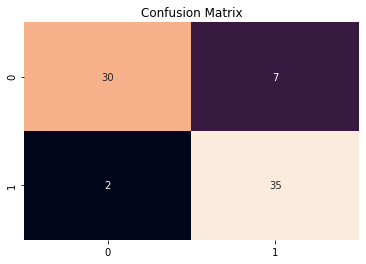

In [5]:
model_path = os.path.join('./LSTM/bi_results', 'LSTM32.h5')
clf = load_model(model_path, compile=False)

pred = clf.predict(test_data).reshape(-1)
pred = (pred > 0.5).astype(int)
metrics = evaluate(test_labels, pred)

print(classification_report(test_labels, pred))
cm = confusion_matrix(test_labels, pred)
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.show()